In [80]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [81]:
train_image_path = glob.glob('./dataset/dc_2000/train/*/*.jpg')

In [82]:
np.random.shuffle(train_image_path)

In [83]:
len(train_image_path)

2000

In [84]:
train_image_path[:5]

['./dataset/dc_2000/train\\dog\\dog.372.jpg',
 './dataset/dc_2000/train\\cat\\cat.389.jpg',
 './dataset/dc_2000/train\\cat\\cat.149.jpg',
 './dataset/dc_2000/train\\dog\\dog.114.jpg',
 './dataset/dc_2000/train\\cat\\cat.861.jpg']

In [85]:
train_image_path[-5:]

['./dataset/dc_2000/train\\cat\\cat.770.jpg',
 './dataset/dc_2000/train\\dog\\dog.556.jpg',
 './dataset/dc_2000/train\\dog\\dog.432.jpg',
 './dataset/dc_2000/train\\dog\\dog.778.jpg',
 './dataset/dc_2000/train\\dog\\dog.790.jpg']

# 提取标签实验

In [86]:
p = './dataset/dc_2000/train\\dog\\dog.995.jpg'

In [87]:
p.split('\\')

['./dataset/dc_2000/train', 'dog', 'dog.995.jpg']

In [88]:
p.split('\\')[1]

'dog'

In [89]:
p.split('\\')[1] == 'cat'

False

In [90]:
int(p.split('\\')[1] == 'cat')

0

# 提取图像标签

In [91]:
train_image_label = [int(path.split('\\')[1] == 'cat') for path in train_image_path]

In [92]:
train_image_label[:5]

[0, 1, 1, 0, 1]

In [93]:
train_image_label[-5:]

[1, 0, 0, 0, 0]

In [94]:
def load_preprosessing_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, [360, 360])
    
    #图像增强
    #随机裁剪，需要输入channels
    image = tf.image.random_crop(image, [256, 256, 3])
    #随机左右翻转
    image = tf.image.random_flip_left_right(image)
    #随机上下翻转
    image = tf.image.random_flip_up_down(image)
    #随机调节亮度，0.5表示随机改变的范围
    #image = tf.image.random_brightness(image, 0.5)
    #随机调节对比度
    #image = tf.image.random_contrast(image, 0, 1)
    
    image = tf.cast(image, tf.float32)
    image = image/255.0
    #tf.image.convert_image_dtype
    #如果不是float32类型它会自动转型和归一化
    # [1, 0, 0] --> [[1], [0], [0]]
    label = tf.reshape(label, [1])
    return image, label

In [95]:
train_image_dataset = tf.data.Dataset.from_tensor_slices((train_image_path, train_image_label))

In [96]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [97]:
train_image_dataset = train_image_dataset.map(load_preprosessing_image, num_parallel_calls=AUTOTUNE)

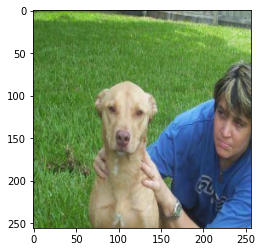

In [98]:
for img, label in train_image_dataset.take(1):
    plt.imshow(img)

In [99]:
test_image_path = glob.glob('./dataset/dc_2000/test/*/*.jpg')
test_image_label = [int(path.split('\\')[1] == 'cat') for path in test_image_path]

test_image_dataset = tf.data.Dataset.from_tensor_slices((test_image_path, test_image_label))
test_image_dataset = test_image_dataset.map(load_preprosessing_image, num_parallel_calls=AUTOTUNE)

In [100]:
test_count = len(test_image_path)

In [101]:
BATCH_SIZE = 48
train_count = len(train_image_path)

In [102]:
train_image_dataset = train_image_dataset.shuffle(train_count).batch(BATCH_SIZE)
#prefetch速度稍微会快
train_image_dataset = train_image_dataset.prefetch(buffer_size = AUTOTUNE)

In [103]:
train_image_dataset

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 1)), types: (tf.float32, tf.int32)>

In [104]:
test_image_dataset = test_image_dataset.batch(BATCH_SIZE)
test_image_dataset = test_image_dataset.prefetch(buffer_size = AUTOTUNE)

# 验证数据集的数据正确性

In [105]:
imgs, labels = next(iter(train_image_dataset))

In [106]:
imgs.shape

TensorShape([48, 256, 256, 3])

In [107]:
labels.shape

TensorShape([48, 1])

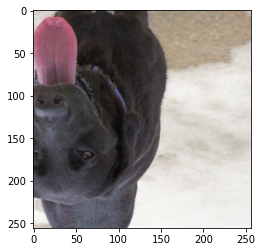

In [108]:
plt.imshow(imgs[0])

In [109]:
labels[0:10]

<tf.Tensor: shape=(10, 1), dtype=int32, numpy=
array([[0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0]])>

In [110]:
imgs, labels = next(iter(test_image_dataset))

In [111]:
labels[0:10]

<tf.Tensor: shape=(10, 1), dtype=int32, numpy=
array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])>

In [112]:
#可参考VGG网络架构
#添加批标准化能够使模型层数更加深，并且正则化抑制过拟合。
model = keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (1, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (1, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (1, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])

In [113]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
batch_normalization_14 (Batc (None, 254, 254, 64)      256       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 252, 252, 64)      36928     
_________________________________________________________________
batch_normalization_15 (Batc (None, 252, 252, 64)      256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 124, 124, 128)     73856     
_________________________________________________________________
batch_normalization_16 (Batc (None, 124, 124, 128)    

In [114]:
pred = model(imgs)

In [115]:
pred.shape

TensorShape([48, 1])

In [116]:
np.array([p[0].numpy() for p in tf.cast(pred > 0, tf.int32)])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [117]:
np.array([l[0].numpy() for l in labels])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [118]:
#losses函数大小写区别
#大写返回可调用对象
#若模型输出没有激活函数，需要from_logits=True

#小写需要把输入值和预测值都输入，直接放回交叉熵的值。

loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [119]:
loss_function([[0.], [0.], [1.], [1.]], [[1.], [1.], [1.], [1.]])

<tf.Tensor: shape=(), dtype=float32, numpy=0.81326175>

In [120]:
tf.keras.losses.binary_crossentropy([0., 0., 1., 1.], [1., 1., 1., 1.])

<tf.Tensor: shape=(), dtype=float32, numpy=7.6666193>

In [121]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [122]:
epoch_loss_avg = tf.keras.metrics.Mean('train_loss')
train_accuracy = tf.keras.metrics.Accuracy()

In [123]:
epoch_loss_avg_test = tf.keras.metrics.Mean('test_loss')
test_accuracy = tf.keras.metrics.Accuracy()

In [124]:
def train_step(model, images, labels):
    #1.创建上下文模拟器，记录整个运算过程
    with tf.GradientTape() as t:
        #2.调用model，得出预测值
        pred = model(images)
        #3.调用loss_function，得出损失值
        #loss_step = loss_function(labels, pred)
        loss_step = tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels, pred)
    #4.调用gradient，计算出loss与可训练参数的梯度
    grads = t.gradient(loss_step, model.trainable_variables)
    #5.应用optimizer，对梯度和可训练参数进行优化
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    epoch_loss_avg(loss_step)
    train_accuracy(labels, tf.cast(pred>0, tf.int32))

In [125]:
def test_step(model, images, labels):
    #pred = model.predict(images)
    pred = model(images, training = False)
    #loss_step = loss_function(labels, pred)
    loss_step = tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels, pred)
    epoch_loss_avg_test(loss_step)
    test_accuracy(labels, tf.cast(pred>0, tf.int32))

In [126]:
train_loss_results = []
train_acc_results = []

In [127]:
test_loss_results = []
test_acc_results = []

# 自定义训练保存模型

In [128]:
cp_dir = './training_checkpoint/custom_train_cp'
#前缀
cp_prefix = os.path.join(cp_dir, 'ckpt')

In [129]:
checkpoint = tf.train.Checkpoint(optimizer = optimizer,
                                 model = model
)

In [51]:
num_epochs = 5

In [52]:

for epoch in range(num_epochs):
    #train数据
    for imgs_, labels_ in train_image_dataset:
        train_step(model, imgs_, labels_)
        print('.', end = '')
    print()
    
    train_loss_results.append(epoch_loss_avg.result())
    train_acc_results.append(train_accuracy.result())
    
    print('Epoch:{} is finished, train_loss = {:.3f}, train_acc = {:.3f}'.format(epoch + 1,
                                                                     epoch_loss_avg.result(),
                                                                     train_accuracy.result()))
    #test数据
    for imgs_, labels_ in test_image_dataset:
        test_step(model, imgs_, labels_)
        print('*', end = '')
    print()
    
    test_loss_results.append(epoch_loss_avg_test.result())
    test_acc_results.append(test_accuracy.result())
    
    print('                     test_loss = {:.3f}, test_acc = {:.3f}'.format(
                                                                     epoch_loss_avg_test.result(),
                                                                     test_accuracy.result()))
    epoch_loss_avg.reset_states()
    train_accuracy.reset_states()
    epoch_loss_avg_test.reset_states()
    test_accuracy.reset_states()

    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = cp_prefix)

..........................................
Epoch:1 is finished, train_loss = 0.751, train_acc = 0.502
*********************
                     test_loss = 0.723, test_acc = 0.500
..........................................
Epoch:2 is finished, train_loss = 0.730, train_acc = 0.503
*********************
                     test_loss = 0.846, test_acc = 0.500
..........................................
Epoch:3 is finished, train_loss = 0.807, train_acc = 0.505
*********************
                     test_loss = 0.737, test_acc = 0.500
..........................................
Epoch:4 is finished, train_loss = 0.803, train_acc = 0.481
*********************
                     test_loss = 0.694, test_acc = 0.500
..........................................
Epoch:5 is finished, train_loss = 0.754, train_acc = 0.513
*********************
                     test_loss = 0.698, test_acc = 0.500


In [130]:
#从最新的检查点恢复
checkpoint.restore(tf.train.latest_checkpoint(cp_dir))

In [138]:
#test_image_dataset.get_shape([1, ])
tf.argmax(model(imgs, training = False), axis = -1).numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

In [133]:
labels.numpy()

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [134]:
#求准确率
(tf.argmax(model(imgs, training = False), axis = -1).numpy() == labels.numpy()).sum() / len(labels)

0.0